# COGS 108 - EDA Checkpoint

# Names

- Cassandra Henrickson
- Daniel Han
- Ezra Lu
- Jasmine Qiang
- Wing Leung (Calvin)

<a id='research_question'></a>
# Research Question

How is the severity of the traffic jam due to a car crash impacted as a result of where the accident occurs and different weather conditions?

# Setup

In [1]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(style="white", font_scale=2)

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# make sure pandas, numpy, and statistics are imported
import pandas as pd
import numpy as np
import statistics

import warnings
warnings.filterwarnings('ignore')

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('US_Accidents_Dec20.csv')

In [3]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', nan,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow',

In [5]:
print('Total observations: ', len(df))

Total observations:  4229394


# Data Cleaning

### 1.1a - Seeing the columns and number of accidents we are working with

In [6]:
#49 different variables
df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [7]:
# San Diego has 29416 accidents
san_diego = df[df['City'] == 'San Diego']
accident_sandiego = san_diego['City'].count()
accident_sandiego

29401

### 1.1b - Look at the different weather conditions in San Diego and the number of their occurrences

In [8]:
#all of the weather conditions in San Diego
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', nan,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow',

In [9]:
#number of accidents per weather condition
df['Weather_Condition'].value_counts()

Fair                         899305
Clear                        808181
Mostly Cloudy                571419
Partly Cloudy                397204
Overcast                     382485
                              ...  
Blowing Sand                      1
Partial Fog / Windy               1
Thunder and Hail / Windy          1
Dust Whirls                       1
Sand / Dust Whirls Nearby         1
Name: Weather_Condition, Length: 131, dtype: int64

### 1.2 - Slicing the dataframe to only include the columns and variables of interest

In [10]:
#slicing df to only include columns we need - Severity, City, Weather Condition, Junction, Stop, and Traffic Signal
df = df.loc[:, ['Severity', 'City', 'Weather_Condition', 'Junction', 'Stop', 'Traffic_Signal']]

#slicing to only get car accidents that happened in San Diego
df = df.loc[df['City'] == 'San Diego']

In [11]:
df['Weather_Condition'].unique()

array(['Scattered Clouds', 'Mostly Cloudy', 'Overcast', 'Clear',
       'Partly Cloudy', 'Haze', 'Mist', 'Light Rain', 'Rain',
       'Heavy Rain', nan, 'Fog', 'Drizzle', 'Light Drizzle', 'Cloudy',
       'Fair', 'Partly Cloudy / Windy', 'Smoke', 'Light Snow', 'T-Storm',
       'Thunder in the Vicinity', 'Patches of Fog', 'Heavy T-Storm',
       'Thunderstorms and Rain', 'Heavy Thunderstorms and Rain',
       'Volcanic Ash', 'Shallow Fog', 'Mostly Cloudy / Windy',
       'Rain / Windy', 'Light Rain with Thunder', 'N/A Precipitation',
       'Fair / Windy', 'Heavy Rain / Windy',
       'Light Thunderstorms and Rain'], dtype=object)

### 1.3 - Group different weather conditions together into "Rain", "Cloudy", "Clear", and "Fog".

We decided to combine the different weather data into four main weather categories - Rain, Cloudy, Clear, and Fog, as many of the weather categories are similar (eg "Light Rain" and "Heavy Rain" are both in the "Rain" category) and can lead to similar driving hazards (eg any rain leads to slippery roads). The details of which weather categories we grouped together can be seen below. 

In [12]:
#Combine 'Fair' & 'Fair / Windy' to 'Clear'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Fair'], 'Clear')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Fair / Windy'], 'Clear')

#Combine 'Light Rain' & 'Heavy Rain' & 'Light Rain with Thunder' &
#'Rain / Windy' & 'Thunderstorms and Rain' &
#'Heavy Rain / Windy' & 'Heavy Thunderstorms and Rain' &
#'Light Thunderstorms and Rain' & 'Light Drizzle' & 'Drizzle' to 'Rain'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Light Rain'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Heavy Rain'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Light Rain with Thunder'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Rain / Windy'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Thunderstorms and Rain'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Heavy Rain / Windy'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Heavy Thunderstorms and Rain'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Light Drizzle'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Drizzle'], 'Rain')

#Combined 'Haze' & 'Shallow Fog' & 'Patches of Fog' &
#'Mist' to 'Fog'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Haze'], 'Fog')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Shallow Fog'], 'Fog')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Patches of Fog'], 'Fog')

#Combine 'Overcast' & 'Mostly Cloudy' &'Partly Cloudy' & 'Mostly Cloudy / Windy' &
#'Partly Cloudy / Windy' to 'Cloudy'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Overcast'], 'Cloudy')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Mostly Cloudy'], 'Cloudy')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Partly Cloudy'], 'Cloudy')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Mostly Cloudy / Windy'], 'Cloudy')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Partly Cloudy / Windy'], 'Cloudy')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Scattered Clouds'], 'Cloudy')

In [13]:
#number of accidents per weather condition in grouped dataset
df['Weather_Condition'].value_counts()

Cloudy                          15199
Clear                           11152
Rain                             2103
Fog                               739
Mist                               12
Thunder in the Vicinity            11
Light Snow                          9
Smoke                               5
T-Storm                             2
N/A Precipitation                   2
Heavy T-Storm                       2
Volcanic Ash                        1
Light Thunderstorms and Rain        1
Name: Weather_Condition, dtype: int64

### 1.4a - Grouping traffic accidents that took place elsewhere on the road in a separate column 

In [14]:
#group all other traffic accidents that occurred elsewhere on the road into a column "other place"
#if 'other place' = 'True', accident took place other than at a Junction, Stop, or Traffic Signal

df['equal_or_lower_than_3?'] = df[df==False].count(axis=1)
df['Other place'] = df['equal_or_lower_than_3?'].apply(lambda x: 'True' if x == 3 else 'False')

#set order of column names
df = df[['Severity', 'City', 'Weather_Condition', 'Junction', 'Stop', 'Traffic_Signal', 'equal_or_lower_than_3?','Other place']]


df.head(7)

,Severity,City,Weather_Condition,Junction,Stop,Traffic_Signal,equal_or_lower_than_3?,Other place
42886,3,San Diego,Cloudy,False,False,False,3,True
42887,3,San Diego,Cloudy,False,False,False,3,True
42905,2,San Diego,Cloudy,False,False,False,3,True
42909,3,San Diego,Cloudy,False,False,False,3,True
42951,3,San Diego,Cloudy,True,False,False,2,False
42952,2,San Diego,Cloudy,False,False,False,3,True
42980,2,San Diego,Clear,False,False,False,3,True


### 1.4b - See how many accidents took place somewhere other than at a Junction, Stop Sign, or Traffic Signal

In [15]:
#24672 accidents took place elsewhere on the road; 4744 accidents took place at a Junction, Stop, or Traffic Signal
df['Other place'].value_counts()

True     24660
False     4741
Name: Other place, dtype: int64

### 1.5 - Only include specific weather conditions in our dataframe and look at their values

In [16]:
#slicing df to only include car accident observations with certain weather conditions
#reset index
df = df.loc[(df['Weather_Condition'] =='Rain') \
            | (df['Weather_Condition'] == 'Fog') \
            | (df['Weather_Condition'] == 'Cloudy') \
            | (df['Weather_Condition'] == 'Clear')].reset_index()

We decided to exclude weather categories that had fewer than 25 occurrences at a car accident because that is not representative of common San Diego weather and did not relate to our analysis as a whole.

In [17]:
#final number of weather conditions and number of accidents per condition
df['Weather_Condition'].value_counts()

Cloudy    15199
Clear     11152
Rain       2103
Fog         739
Name: Weather_Condition, dtype: int64

### 1.6a - Check for missing data and total accidents in our cleaned dataframe. 

In [18]:
#check for missing data                                                              
print(df['Severity'].hasnans)
print(df['City'].hasnans)
print(df['Weather_Condition'].hasnans)
print(df['Junction'].hasnans)
print(df['Stop'].hasnans)
print(df['Traffic_Signal'].hasnans)

False
False
False
False
False
False


In [19]:
#number of accidents now, with cleaned data
#print total number of accidents with cleaned data set
print(df['City'].count())

29193


### 1.6b - Show final, cleaned dataframe

In [20]:
#drop index column and calculation column 'equal_or_lower_than_3?' that determined if accident took place elsewhere
df = df.drop(columns = ['index', 'equal_or_lower_than_3?'])

#show cleaned car accident dataset
df.head(10)

,Severity,City,Weather_Condition,Junction,Stop,Traffic_Signal,Other place
0,3,San Diego,Cloudy,False,False,False,True
1,3,San Diego,Cloudy,False,False,False,True
2,2,San Diego,Cloudy,False,False,False,True
3,3,San Diego,Cloudy,False,False,False,True
4,3,San Diego,Cloudy,True,False,False,False
5,2,San Diego,Cloudy,False,False,False,True
6,2,San Diego,Clear,False,False,False,True
7,3,San Diego,Cloudy,False,False,False,True
8,2,San Diego,Cloudy,False,False,False,True
9,3,San Diego,Cloudy,False,False,False,True


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

### 2.1 - Severity of Traffic: Weather Condition

#### 2.1a - Explore individual distributions of severity and weather conditions

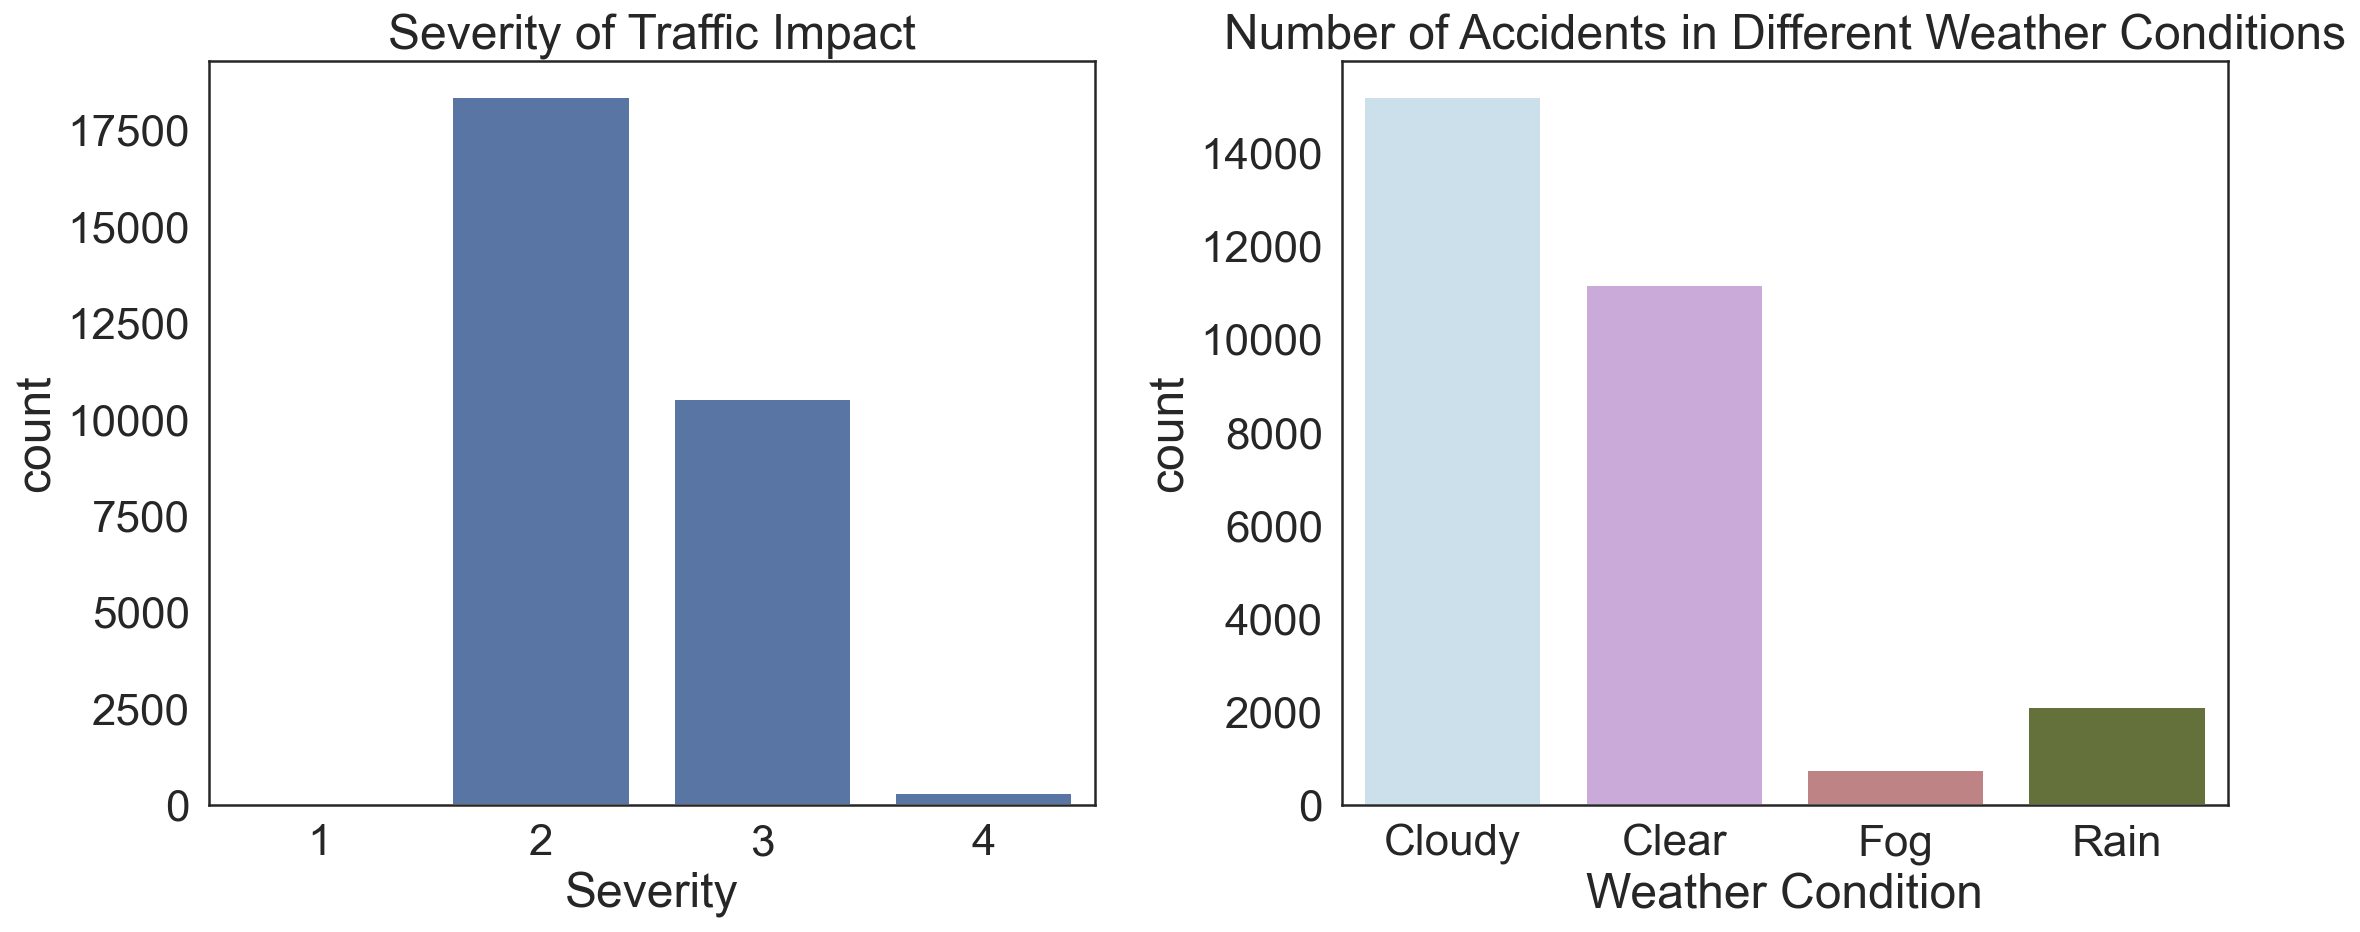

In [21]:
#distribution of traffic severity
plt.subplot(1, 2, 1) 
severity = sns.countplot(data = df, x = 'Severity', color = 'b')
severity.set_title('Severity of Traffic Impact')

#distribution of weather conditions
plt.subplot(1, 2, 2) 
weather = sns.countplot(data = df, x = 'Weather_Condition', palette = sns.color_palette("cubehelix_r"))
weather.set_title('Number of Accidents in Different Weather Conditions')
weather.set_xlabel('Weather Condition')

plt.tight_layout()

interpretation of countplots 
- In the countplot that is titled "Severity of Traffic Impact", the median severity is 2 while the severity level 3 is slightly less than half of 2
- The highest number of accidents occurred in cloudy weather with the next highest accidents occurring in clear weather. Rainy conditions surprisingly came in 3rd highest and foggy conditions came in last. Weather conditions in San Diego are most likely to be clear or cloudy, hence our data resembles most of the accidents taking place in when it is clear/cloudy. 
- positively skewed

#### 2.1b - Explore relationship between severity of traffic impact and different weather conditions (Rain, Overcast, Clear, Fog)

Text(0, 0.5, 'Number of Accidents')

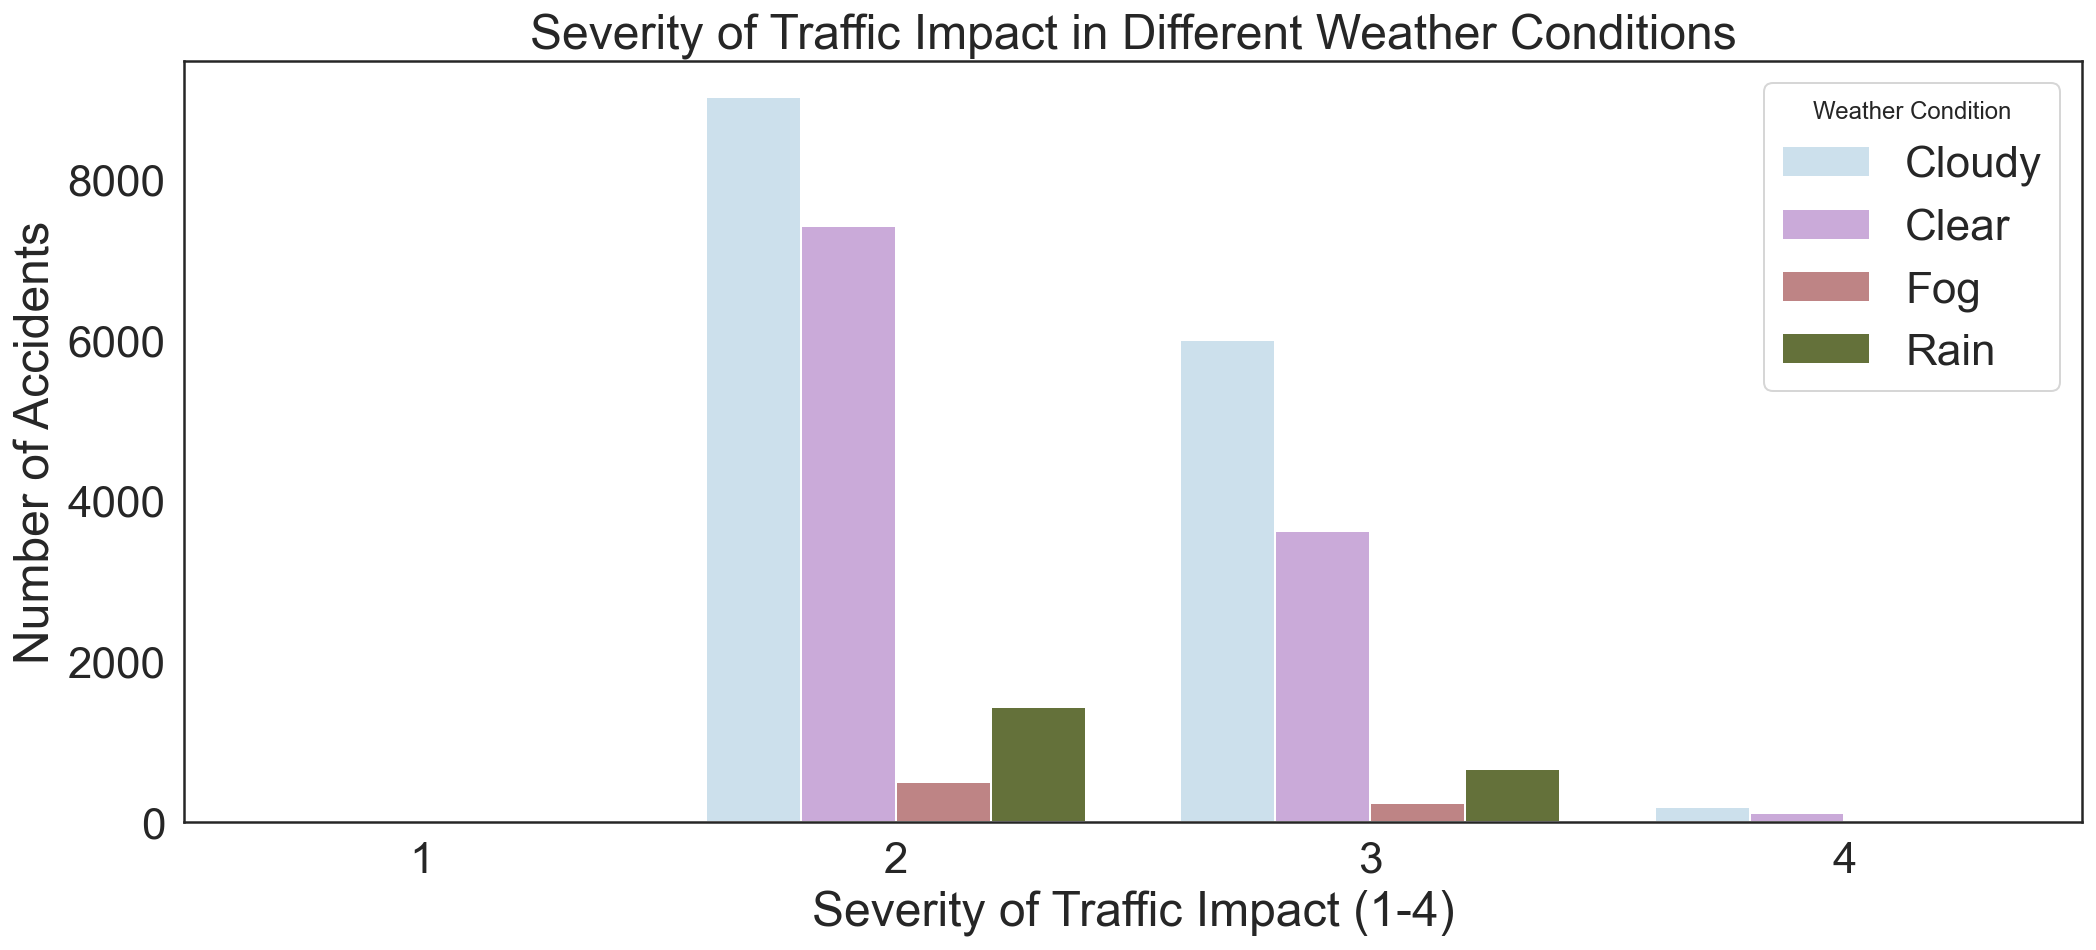

In [22]:
#show the severity of traffic impact in different weather conditions
severity_weather_condition = sns.countplot(data = df, x = 'Severity', hue = 'Weather_Condition', palette = sns.color_palette("cubehelix_r"))

#setting axis and legend titles
plt.legend(title='Weather Condition')
severity_weather_condition.set_title('Severity of Traffic Impact in Different Weather Conditions')
severity_weather_condition.set_xlabel('Severity of Traffic Impact (1-4)')
severity_weather_condition.set_ylabel('Number of Accidents')

Explanation/Interpretation of graph
- As seen in our countplot representations, there are more accidents occurring in the severity level 2 range
- Regardless of severity level, accidents take place the most in cloudy conditions with clear conditions following afterwards 
- We think that because there are not many rainy days in San Diego, there is not much data that shows the severity of traffic impact in rainy conditions. Most of the time, there are clear skies or cloudy conditions, so we expect there to be more accidents in these 2 weather conditions.

#### 2.1c - Hypothesis Test

- __Null Hypothesis__: Traffic severity is not associated with weather conditions.
- __Alternative Hypothesis__: Traffic severity is associated with weather conditions.
- Alpha/Significance Level: 0.05
- Test Statistic: chi-squared test

In [23]:
#chi-squared test 

#find count values for all categorical variables
weather_count_values = df.groupby(['Severity','Weather_Condition']).size().reset_index(name='count')
weather_count_values

,Severity,Weather_Condition,count
0,1,Clear,2
1,1,Cloudy,7
2,1,Fog,1
3,2,Clear,7416
4,2,Cloudy,9017
5,2,Fog,497
6,2,Rain,1426
7,3,Clear,3624
8,3,Cloudy,5993
9,3,Fog,237


In [24]:
#chi-squared test 

#find count values for all categorical variables
weather_count_values = df.groupby(['Severity','Weather_Condition']).size().reset_index(name='count')
weather_count_values

,Severity,Weather_Condition,count
0,1,Clear,2
1,1,Cloudy,7
2,1,Fog,1
3,2,Clear,7416
4,2,Cloudy,9017
5,2,Fog,497
6,2,Rain,1426
7,3,Clear,3624
8,3,Cloudy,5993
9,3,Fog,237


In [139]:
observed_table= pd.crosstab(df['Weather_Condition'], df['Severity']) 
observed_table = pd.DataFrame(observed_table,index=['Clear','Cloudy','Fog','Rain','Total'])
observed_table['Total'] = observed_table.sum(axis=1)
observed_table.iloc[-1] = observed_table.iloc[-1] = observed_table.sum(axis=0)
observed_table

Severity,1,2,3,4,Total
Clear,2.0,7416.0,3624.0,110.0,11152.0
Cloudy,7.0,9017.0,5993.0,182.0,15199.0
Fog,1.0,497.0,237.0,4.0,739.0
Rain,0.0,1426.0,664.0,13.0,2103.0
Total,10.0,18356.0,10518.0,309.0,29193.0


In [26]:
chi2, p, dof, expected = chi2_contingency(observed=observed_table)
expected_table = pd.DataFrame(expected,\
                                           index=['Clear','Cloudy','Fog','Rain','Total'],\
                                           columns=['1','2','3','4','Total'])
expected_table

,1,2,3,4,Total
Clear,3.820094,7012.164286,4017.974720,118.040900,11152.0
Cloudy,5.206385,9556.840475,5476.075840,160.877299,15199.0
Fog,0.253143,464.669065,266.255678,7.822115,739.0
Rain,0.720378,1322.326174,757.693762,22.259686,2103.0
Total,10.000000,18356.000000,10518.000000,309.000000,29193.0


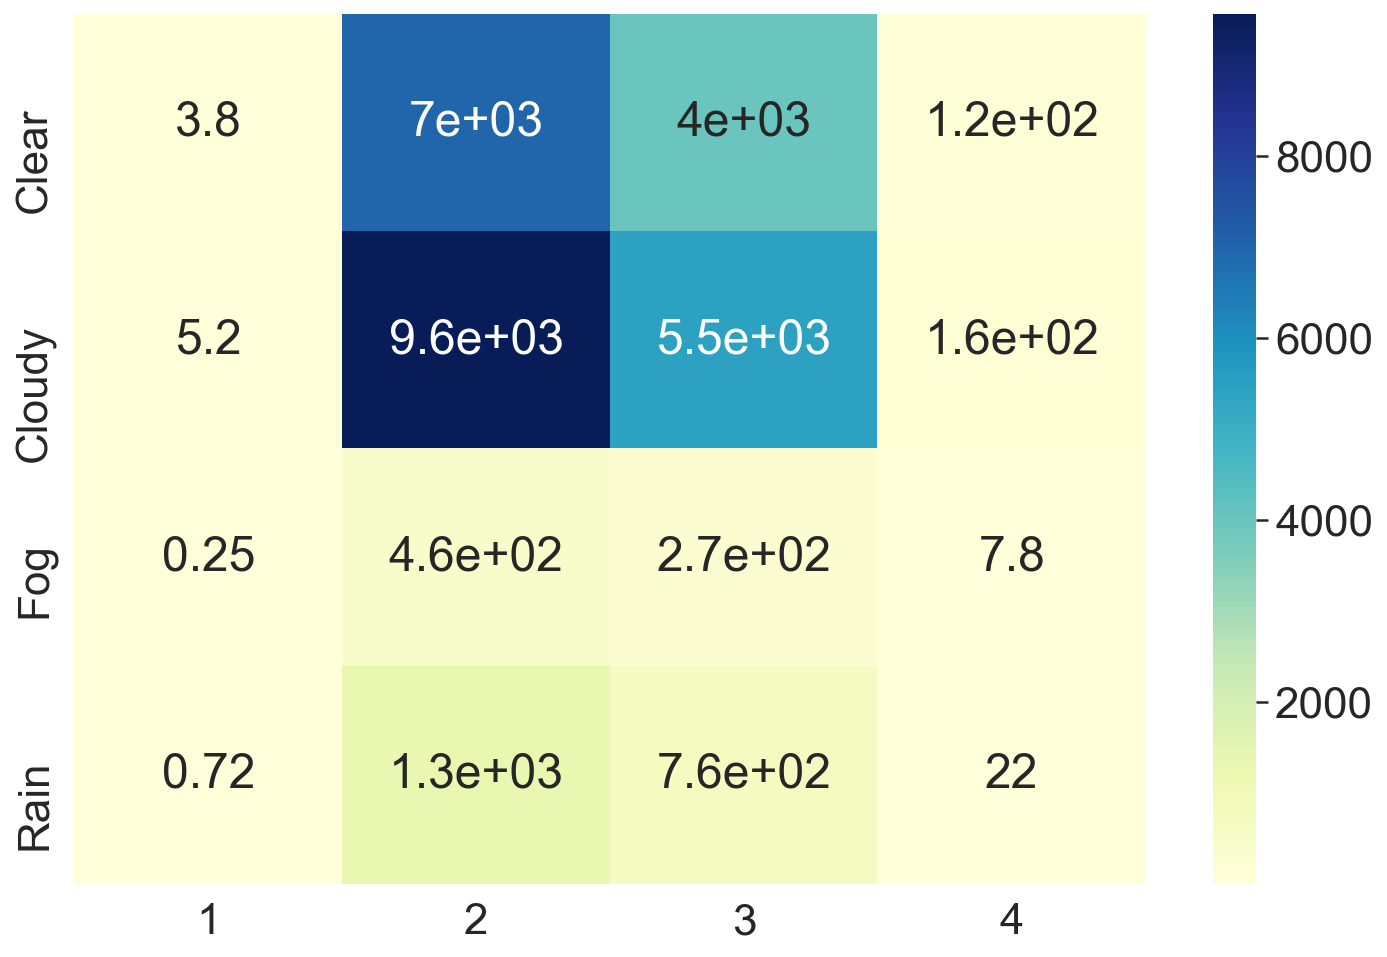

In [27]:
heat_map = expected_table.iloc[:4]
heat_map = heat_map.drop(columns='Total')
heat_map
plt.figure(figsize=(12,8)) 
sns.heatmap(heat_map, annot=True, cmap="YlGnBu")

In [28]:
p

9.214628124934124e-30

#### Conclusions of Hypothesis Test:
- Since 9e-30 < 0.05, we can reject the null hypothesis that traffic severity is not influenced by weather condition. 
- Our data is statisically significant because our P value is lower than our Alpha value of 0.05

### 2.2 - Severity of Traffic Impact: Road location

#### 2.2a -  Explore relationship between severity of traffic and different road locations (Junction, Stop Sign, Traffic Signal)

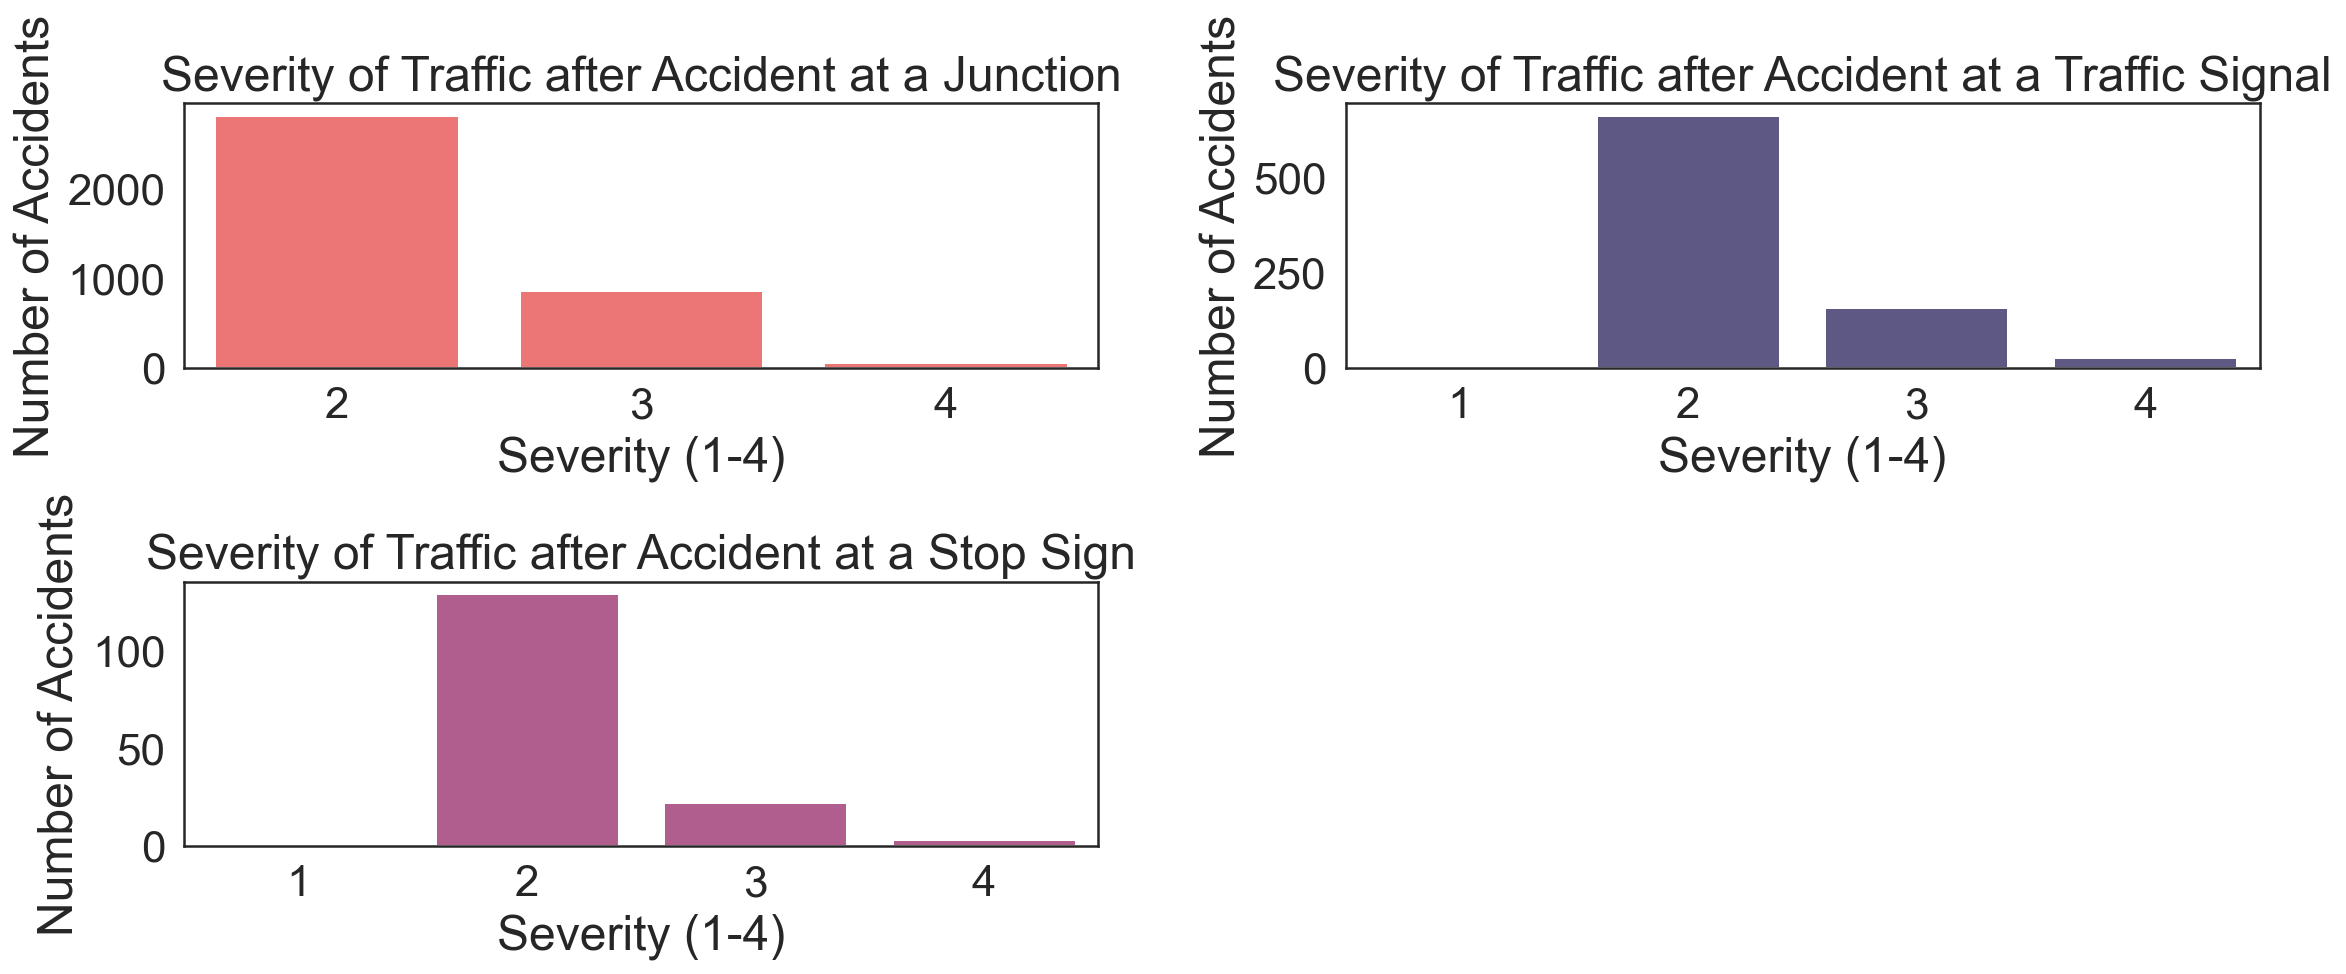

In [29]:
#severity of traffic impact due to different road locations - countplots

#severity of traffic at junction
plt.subplot(2, 2, 1)  
junction = sns.countplot(df[df['Junction'] == True ]['Severity'], color = '#ff6361')

#set axis titles
junction.set_title('Severity of Traffic after Accident at a Junction')
junction.set_xlabel('Severity (1-4)')
junction.set_ylabel('Number of Accidents')

#severity of traffic at traffic signal
plt.subplot(2, 2, 2)
traffic_signal = sns.countplot(df[df['Traffic_Signal'] == True ]['Severity'], color = '#58508d')

#set axis titles
traffic_signal.set_title('Severity of Traffic after Accident at a Traffic Signal')
traffic_signal.set_xlabel('Severity (1-4)')
traffic_signal.set_ylabel('Number of Accidents')

#severity of traffic at stop sign
plt.subplot(2, 2, 3)  
stop = sns.countplot(df[df['Stop'] == True ]['Severity'], color = '#bc5090')

#set axis titles
stop.set_title('Severity of Traffic after Accident at a Stop Sign')
stop.set_xlabel('Severity (1-4)')
stop.set_ylabel('Number of Accidents')

#set scale...?
plt.tight_layout()

Interpretation/Explanation of graph
- Note: Since we are focusing only on accidents that occurred at these three road locations - Junction, Traffic Signal, and Stop sign - there are only 4744 observations accounted for in these graphs, as 24672 accidents occurred at somewhere else.
- There is a significantly higher number of accidents at a junction
- The least number of accidents occurred at a stop sign
- The most frequent severity of traffic (2) occured at a junction; the second most frequent location that an accident occurred was at a traffic signal, and the third most frequent was at a stop sign.



#### 2.2a - Hypothesis Test

- __Null Hypothesis__: Traffic severity is not associated with road locations. 
- __Alternative Hypothesis__: Traffic severity is associated with road locations.
- Alpha/Significance Level: 0.05
- Test Statistic: chi-square test

In [69]:
#chi-squared test 

#find count values for all categorical variables
junc_sever = df[df['Junction']==True]['Severity'].value_counts()
sign_sever = df[df['Traffic_Signal']==True]['Severity'].value_counts()
stop_sever = df[df['Stop']==True]['Severity'].value_counts()
print(junc_sever)
print(sign_sever)
print(stop_sever)

2    2807
3     857
4      58
Name: Severity, dtype: int64
2    663
3    158
4     27
1      1
Name: Severity, dtype: int64
2    129
3     22
4      3
1      1
Name: Severity, dtype: int64


In [155]:
#Observed table based on categorical variables between severity and road location

observed_table2 = pd.DataFrame(np.array([[0,junc_sever[2],junc_sever[3],junc_sever[4]],\
                                          [sign_sever[1],sign_sever[2],sign_sever[3],sign_sever[4]],\
                                          [stop_sever[1],stop_sever[2],stop_sever[3],stop_sever[4]]]),\
                                       index=['Junction','Traffic Signal','Stop'],\
                                       columns=['1','2','3','4'])
observed_table2['Total'] = observed_table2.sum(axis=1)
observed_table2 = pd.DataFrame(observed_table2,index=['Junction','Traffic Signal','Stop','Total'])
observed_table2.iloc[-1] = observed_table2.iloc[-1] = observed_table2.sum(axis=0)
observed_table2

,1,2,3,4,Total
Junction,0.0,2807.0,857.0,58.0,3722.0
Traffic Signal,1.0,663.0,158.0,27.0,849.0
Stop,1.0,129.0,22.0,3.0,155.0
Total,2.0,3599.0,1037.0,88.0,4726.0


In [159]:
chi2, p, dof, expected = chi2_contingency(observed=observed_table2)
expected_table = pd.DataFrame(expected,\
                                           index=['Junction','Traffic Signal','Stop','Total'],\
                                           columns=['1','2','3','4','Total'])
expected_table

,1,2,3,4,Total
Junction,1.575116,2834.421921,816.697842,69.305121,3722.0
Traffic Signal,0.359289,646.540626,186.291367,15.808718,849.0
Stop,0.065595,118.037452,34.010791,2.886162,155.0
Total,2.000000,3599.000000,1037.000000,88.000000,4726.0


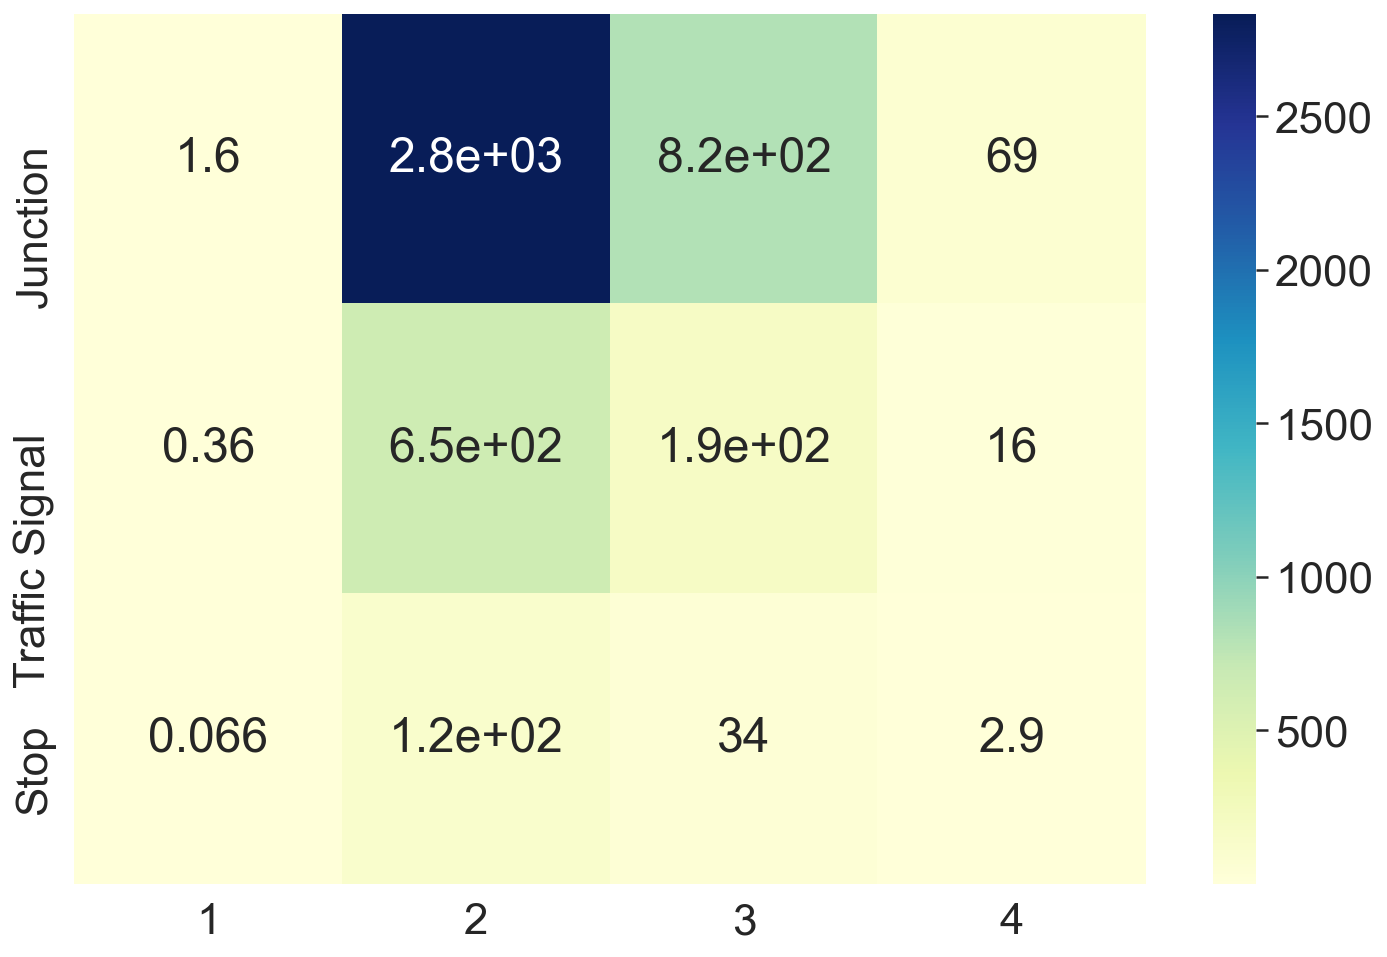

In [160]:
heat_map = expected_table.iloc[:3]
heat_map = heat_map.drop(columns='Total')
heat_map
plt.figure(figsize=(12,8)) 
sns.heatmap(heat_map, annot=True, cmap="YlGnBu")

In [161]:
p

0.00015190037968088906

#### Conclusions of Hypothesis Test:
- Since our P value is < 0.05, we can reject the null hypothesis that traffic severity is not influenced by road location of the car crash.

### 2.3 - Severity of Traffic: Interaction

#### 2.3a - Explore how the interaction between different weather conditions and road location impacts traffic severity

In [ ]:
#will do later
#heat map of the mean severity and number of accidents based on weather and location
#maybe have two side by side (one mean, one number)

heatmap_df = pd.DataFrame(df, columns = ['Weather_Condition', 'Junction', 'Stop', 'Traffic_Signal', 'Other place'])
heatmap_df
#severity_mean = df['Severity'].mean()

confusion_matrix = pd.crosstab(df['Weather_Condition'], df['Junction'], rownames=['Weather Condition'], colnames=['Junction'])
print (confusion_matrix)


- print out number of accidents per variable to check data

weather vs accident place grid - mean severity and # of accidents
- on grid, would have a heat map (red = mean of severity high; vibrant/transparency = if number of accidents was high) - ordered pairs
    (2.6, 1500)
    - two legends, one for color gradient (severity) and one for transparency (eg grayscale) (# accidents)
    - or can have two diff graphs, one for severity and one for # accidents

break up explanations as much as possible. introduce topic and then explain results
hypothesis test to accompnay first and second visualizations, 3rd visualization is something we will explore in proper analysis
- 1.1 - severity in terms of weather
    - hypothesis test: looking just at rain against clear bc its weird there are so few traffic accidents
        null: traffic accidents are 20% more likely to happen in rain than clear weather (look at internet)
        H1: clear distributions are higher than rain distributions 
        - do they crash less in the rain enough to make you reject the null that rain crashes are more likely than clear 
- 1.2 - severity in terms of location
- 1.3 - interaction